Implémentation de résolution numérique approchée des 2 équations couplées du mouvement de précession :
$\frac{dv_x}{dt} = \omega v_y(t), 
\frac{dv_y}{dt} = -\omega v_x(t), 
v_x(0) = V_0,
v_y(0) = 0$
à l'aide de la méthode de descente de gradients sur la fonction d'erreur


In [364]:
#imports
from numpy import pi, cos, sin, dot, zeros, linspace, arange, matmul, concatenate
from numpy.random import randn

Paramètres du modèle

In [365]:
#nombre de coefficients de Fourier ajustables
M = 10
M_range = arange(M) +1

# nombre de points pour la variable indépendante
N = 100
T = linspace(0,1,N)

Paramètres du problème

In [366]:
W = 2*pi #pulsation
V0 = 1 #vitesse initiale

Calculs des vecteurs des cosinus et sinus qui seront souvent utilisés

In [367]:
#matrice de coefficients (m*W*T[i]) de taille NxM
#avec première coordonnée i, et deuxème m
m_w_T = W*matmul(T.reshape((N,1)), M_range.reshape((1,M)))
cos = cos(m_w_T)
sin = sin(m_w_T)

Définition du gradient

In [368]:
def calcGrad(A,B, M, M_range, N, cos, sin) :
    #calcule le gradient de l'erreur par rapport aux
    #2 vecteurs de paramètres A et B
    grad_A = zeros((M))
    grad_B = zeros((M))

    for i in range(N) :
        #valeurs de vx et vy à l'instant T[i]
        vx = V0 + dot(A, cos[i]-1) + dot(B, sin[i])
        vy = - dot(A, sin[i]) + dot(B, cos[i]-1)

        #valeurs des dérivées de vx et vy à l'instant T[i]
        dvx = W*(-dot(M_range*A, sin[i]) + dot(M_range*B, cos[i]))
        dvy = W*(-dot(M_range*A, cos[i]) - dot(M_range*B, sin[i]))

        #différences
        ex = dvx - W*vy
        ey = dvy + W*vx

        #on incrémente les gradients
        #pour A
        dex_dA = W*(1-M_range)*sin[i]
        dey_dA = W*((1-M_range)*cos[i]-1)
        grad_A += ex*dex_dA + ey*dey_dA
        #pour B
        dex_dB = W*((M_range-1)*cos[i]+1)
        dey_dB = W*(1-M_range)*sin[i]
        grad_B += ex*dex_dB + ey*dey_dB

    return grad_A, grad_B

Définition de l'erreur

In [369]:
def calcErreur(A,B, M_range, N, cos, sin)  :

    erreur = 0
    for i in range(N) :
        #valeurs de vx et vy à l'instant T[i]
        vx = V0 + dot(A, cos[i]-1) + dot(B, sin[i])
        vy = - dot(A, sin[i]) + dot(B, cos[i]-1)

        #valeurs des dérivées de vx et vy à l'instant T[i]
        dvx = W*(-dot(M_range*A, sin[i]) + dot(M_range*B, cos[i]))
        dvy = W*(-dot(M_range*A, cos[i]) - dot(M_range*B, sin[i]))

        #différences
        ex = dvx - W*vy
        ey = dvy + W*vx

        erreur += ex**2 + ey**2

    return erreur/2

Calcul matriciel du gradient

In [370]:
d = zeros(2*M)
for l in range(1,M+1) :
    for i in range(N) :
        d[l-1] += (1-l)*cos[i,l-1]-1
        d[l-1+M] += (1-l)*sin[i,l-1]

d*=W**2*V0


mat = zeros((2*M,2*M))

for l in range(1,M+1) :
    for m in range(1,M+1) :
        for i in range(N) :
            mat[l-1,m-1] += (1-l)*(1-m)*sin[i,m-1]*sin[i,l-1]
            mat[l-1,m-1] += ((1-l)*cos[i,l-1]-1)*((1-m)*cos[i,m-1]-1)

            mat[l-1,m-1+M] += (1-l)*sin[i,l-1]*((m-1)*cos[i,m-1]+1)
            mat[l-1,m-1+M] += (1-m)*sin[i,m-1]*((1-l)*cos[i,l-1]-1)

            mat[l-1+M,m-1] += ((l-1)*cos[i,l-1]+1)*(1-m)*sin[i,m-1]
            mat[l-1+M,m-1] += (1-l)*sin[i,l-1]*((1-m)*cos[i,m-1]-1)

            mat[l-1+M,m-1+M] += ((l-1)*cos[i,l-1]+1)*((m-1)*cos[i,m-1]+1)
            mat[l-1+M,m-1+M] += (1-l)*(1-m)*sin[i,m-1]*sin[i,l-1]

mat *= W**2



def calcGrad_mat(A, B, M, mat, d) :
    P = concatenate((A,B))
    G = matmul(mat, P) + d
    return G[:M], G[M:]

Paramètres d'apprentissage

In [371]:
alpha = 6.0906090609060915e-06 #taux d'apprentissage pour la descente de gradients
epochs = 6000 #nombre d'itération

#initialisation des coefficients
A = randn((M))
B = randn((M))

Entraînement

In [372]:
E = [] #evolution de l'erreur

for k in range(epochs) :
    if k%(epochs//10)==0 :
        print("\nCoefficients après",k,"itérations :\n",A,"\n", B)
    
    if k%(epochs//100)==0 :
        E.append(calcErreur(A,B, M_range, N, cos, sin))

    grad_A, grad_B = calcGrad_mat(A, B, M, mat, d)
    A -= alpha*grad_A
    B -= alpha*grad_B


E.append(calcErreur(A,B, M_range, N, cos, sin))


Coefficients après 0 itérations :
 [ 0.06093236 -0.34090604 -1.16292009 -1.40907962  0.48250862 -0.02472549
  0.17372175 -0.70204271  0.01261799 -0.53493834] 
 [-0.71696554 -0.14924729  0.07449603 -1.15760538  0.34150479 -1.39505364
  1.06464997  1.18160084 -0.56632174 -1.18757475]

Coefficients après 600 itérations :
 [ 9.95590447e-01  1.99938029e-03  2.62996648e-04  2.79569795e-05
 -6.55075590e-05 -1.30861723e-04 -2.03090745e-04 -3.20506703e-04
 -6.22293398e-04 -4.92697686e-03] 
 [-4.36016688e-03  1.85029437e-03  1.54985440e-04 -8.74345220e-05
 -1.98421966e-04 -2.92266973e-04 -4.12481783e-04 -6.23657622e-04
 -1.18386019e-03 -9.25292721e-03]

Coefficients après 1200 itérations :
 [ 9.99962238e-01  1.72226303e-05  2.33576195e-06  3.30944174e-07
 -4.54677031e-07 -9.91099322e-07 -1.57082770e-06 -2.50070736e-06
 -4.87685295e-06 -3.87078665e-05] 
 [-3.72810189e-05  1.60061343e-05  1.47896755e-06 -5.79155987e-07
 -1.50095856e-06 -2.26059401e-06 -3.21705331e-06 -4.88352197e-06
 -9.29026593e

Affichage des résultats

In [373]:
print()
print("Coefficients finaux après",epochs,"itérations :",A,B)


Coefficients finaux après 6000 itérations : [ 1.00000000e+00  4.16801402e-16  8.60455562e-17  2.60610850e-17
  1.17431760e-17 -9.42997966e-18 -1.38656134e-17 -3.44860714e-17
 -6.97218806e-17 -5.49282169e-16] [-1.07355239e-21  4.90932005e-22  6.74805818e-23  1.05865885e-23
 -1.15583549e-23 -2.65095895e-23 -4.24916702e-23 -6.79547497e-23
 -1.32828286e-22 -1.05561060e-21]


Affichage graphique de l'erreur

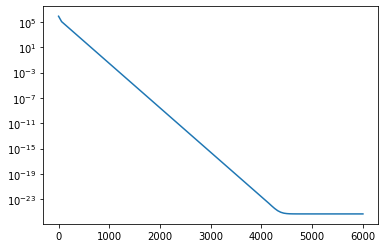

In [377]:
from matplotlib.pyplot import plot, show, yscale, savefig

plot([epochs//100*k for k in range(101)], E)
yscale('log')
#savefig("Erreur_2_DG.jpg")
show()

In [375]:
print(E[int(6000/epochs*100)])

5.24532733625107e-26


Affichage des coefficients trouvés

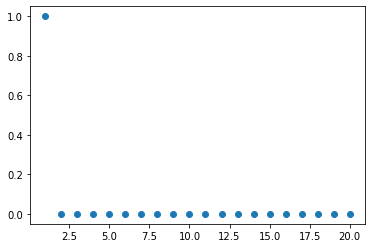

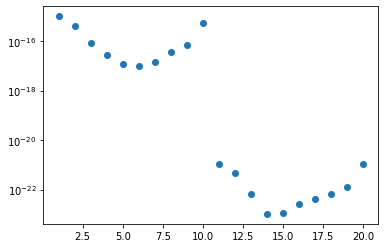

In [376]:
from matplotlib.pyplot import scatter, show, yscale, savefig

P = concatenate((A,B))
#erreur relative sur le premier coefficient
#valeurs théoriques :
P_th = zeros((2*M))
P_th[0] = 1

erreur = abs(P-P_th)

scatter(range(1, 2*M+1), P)
savefig('coefs_2_DG.jpg')
show()

scatter(range(1, 2*M+1), erreur)
yscale('log')
savefig('coefs_2_DG_erreur.jpg')
show()
